# Genetic Algorithm for Pumped Storage Optimisation

In [17]:
import numpy as np
import pandas as pd
import polars as pl
import plotnine as pn
from tqdm.notebook import tqdm
import plotly.express as px
from IPython.display import display, clear_output

import optuna
from optuna.trial import TrialState

background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)

from Actions import GA_discrete_actions

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [18]:
def evaluate_fitness(population, plant_params, prices):

    # To be written according to pumped storage optimisation problem
    fitness_scores = np.array([])

    for parameter_combination in population:

        water_level = plant_params["INITIAL_WATER_LEVEL"]
        fitness_score = 0

        for action, price in zip(parameter_combination, prices["spot"]):
            # Pump (-1)
            if action == -1:
                if water_level + plant_params["PUMP_RATE_M3H"] <= plant_params["MAX_STORAGE_M3"]:
                    fitness_score -= plant_params["PUMP_POWER_MW"] * price
                    water_level += plant_params["PUMP_RATE_M3H"]
                else:
                    fitness_score -= 10_000_000
            # Turbine (1)
            if action == 1:
                if water_level - plant_params["TURBINE_RATE_M3H"] >= plant_params["MIN_STORAGE_M3"]:
                    fitness_score += plant_params["TURBINE_POWER_MW"] * price
                    water_level -= plant_params["TURBINE_RATE_M3H"]
                else:
                    fitness_score -= 10_000_000
            # Do nothing (0)
            # Nothing happens to the fitness score and the water level
        
        fitness_scores = np.append(fitness_scores, fitness_score)

    return fitness_scores

In [19]:
prices = (
    pl.read_csv("Data/spot_prices_utc.csv")
    .with_columns(pl.col("utc_time").str.to_datetime(), pl.col("spot").forward_fill())
    .drop_nulls()
)

In [ ]:
window_size = 24*7

example = prices.filter(
    pl.col("utc_time") >= pd.to_datetime("2022-01-01").tz_localize("UTC")
).head(window_size)

plant_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 5000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 500,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
plant_params["INITIAL_WATER_LEVEL"] = (
    plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
)
plant_params["PUMP_RATE_M3H"] = (
    plant_params["TURBINE_RATE_M3H"] * plant_params["EFFICIENCY"]
)
plant_params["MAX_STORAGE_MWH"] = (
    plant_params["MAX_STORAGE_M3"] / plant_params["TURBINE_RATE_M3H"]
) * plant_params["TURBINE_POWER_MW"]


ga = GA_discrete_actions(
    dna_size=window_size,
    discrete_action_space=[-1, 0, 1],
    elitism=0.5,
    population_size=500,
    mutation_rate=0.5,
    survival_rate=0.25,
    mutation_decay=0.99,
    mutation_limit=0.01,
)

In [21]:
plant_params

{'EFFICIENCY': 0.75,
 'MAX_STORAGE_M3': 5000,
 'MIN_STORAGE_M3': 0,
 'TURBINE_POWER_MW': 100,
 'PUMP_POWER_MW': 100,
 'TURBINE_RATE_M3H': 500,
 'MIN_STORAGE_MWH': 0,
 'INITIAL_WATER_LEVEL_PCT': 0,
 'INITIAL_WATER_LEVEL': 0,
 'PUMP_RATE_M3H': 375.0,
 'MAX_STORAGE_MWH': 1000.0}

In [22]:
population = ga.initial_population
average_fitnesses = []
best_fitnesses = []
generation = 0

while True:
    if (generation == 0) or (np.mean(average_fitnesses[-15:]) < ga.best_fitness * 0.99):
        population = ga.evolve(
            population=population,
            fitnesses=evaluate_fitness(
                population=population, plant_params=plant_params, prices=example
            ),
        )
        average_fitnesses.append(ga.average_fitness)
        best_fitnesses.append(ga.best_fitness)

        if generation % 25 == 0:
            print(
                f"Generation: {generation}, Best Fitness: {ga.best_fitness}, Average Fitness: {ga.average_fitness}, Mutation Rate: {ga.mutation_rate}"
            )
            # clear_output(wait=True)

        generation += 1

    else:
        break

Generation: 0, Best Fitness: -10322299.0, Average Fitness: -178300603.372, Mutation Rate: 0.495
Generation: 25, Best Fitness: 157032.0, Average Fitness: -14469880.826, Mutation Rate: 0.38502157290257755
Generation: 50, Best Fitness: 207872.0, Average Fitness: -10231968.266, Mutation Rate: 0.29947800323308055
Generation: 75, Best Fitness: 254919.0, Average Fitness: -10317235.128, Mutation Rate: 0.2329403875848967
Generation: 100, Best Fitness: 272432.0, Average Fitness: -9369311.294, Mutation Rate: 0.18118600893024847
Generation: 125, Best Fitness: 298861.0, Average Fitness: -9096569.15, Mutation Rate: 0.14093034777023172
Generation: 150, Best Fitness: 311331.0, Average Fitness: -7920070.306, Mutation Rate: 0.10961863468323617
Generation: 175, Best Fitness: 312311.0, Average Fitness: -649642.154, Mutation Rate: 0.0852637154447932
Generation: 200, Best Fitness: 312311.0, Average Fitness: -148761.504, Mutation Rate: 0.06631993905469107
Generation: 225, Best Fitness: 312311.0, Average Fitn

KeyboardInterrupt: 

In [23]:
ga.best_dna

array([ 0., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0., -1., -1., -1.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0., -1.,
       -1., -1., -1., -1.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1.,
        0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.])

In [24]:
history = pd.DataFrame(
    {
        "generation": np.arange(1, len(average_fitnesses) + 1),
        "average": average_fitnesses,
        "best": best_fitnesses,
    }
)

history.head()

,generation,average,best
0,1,-1.783006e+08,-10322299.0
1,2,-9.498107e+07,0.0
2,3,-6.438170e+07,0.0
3,4,-5.362147e+07,0.0
4,5,-4.665657e+07,0.0


In [25]:
ga.best_fitness

312311.0

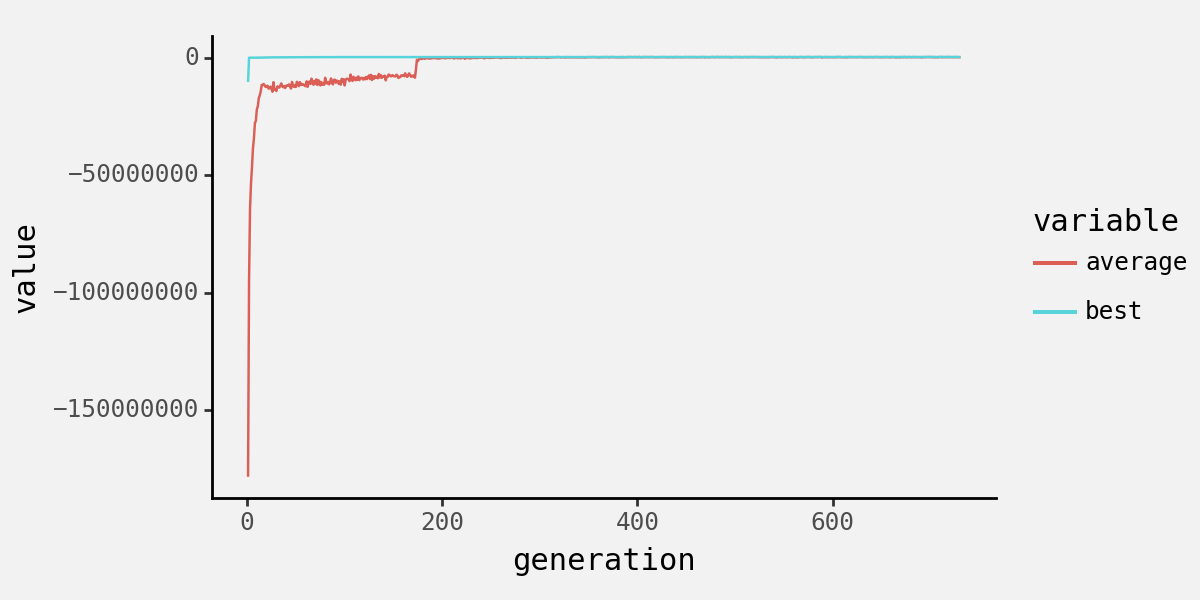

<Figure Size: (600 x 300)>

In [27]:
(
    pn.ggplot(
        data=(
            pd.DataFrame(
                {
                    "average": average_fitnesses,
                    "best": best_fitnesses,
                    "generation": np.arange(1, len(average_fitnesses) + 1),
                }
            )
            # .tail(len(average_fitnesses)-10)
            .melt(id_vars="generation")
        ),
        mapping=pn.aes(x="generation", y="value", colour="variable"),
    )
    + pn.geom_line()
    + pn.theme(figure_size=[6, 3])
    # + pn.scale_y_log10()
)

In [28]:
pd.DataFrame(
                {
                    "average": average_fitnesses,
                    "best": best_fitnesses,
                    "generation": np.arange(1, len(average_fitnesses) + 1),
                }
            ).to_csv("history.csv", index=False)

In [29]:
best_profile = (
    example.to_pandas().assign(
        action=ga.best_dna,
        colour_id=lambda x: np.select(
            [x.action == -1, x.action == 0, x.action == 1],
            ["pump", "nothing", "turbine"],
        ),
        water_level=lambda x: plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
        + np.select(
            [x.action == -1, x.action == 1],
            [plant_params["PUMP_RATE_M3H"], -plant_params["TURBINE_RATE_M3H"]],
            0,
        ).cumsum(),
    )
)

best_profile.head()

,spot,utc_time,action,colour_id,water_level
0,101.54,2022-01-01 00:00:00+00:00,0.0,nothing,0.0
1,52.13,2022-01-01 01:00:00+00:00,-1.0,pump,375.0
2,20.78,2022-01-01 02:00:00+00:00,-1.0,pump,750.0
3,15.66,2022-01-01 03:00:00+00:00,-1.0,pump,1125.0
4,21.47,2022-01-01 04:00:00+00:00,-1.0,pump,1500.0


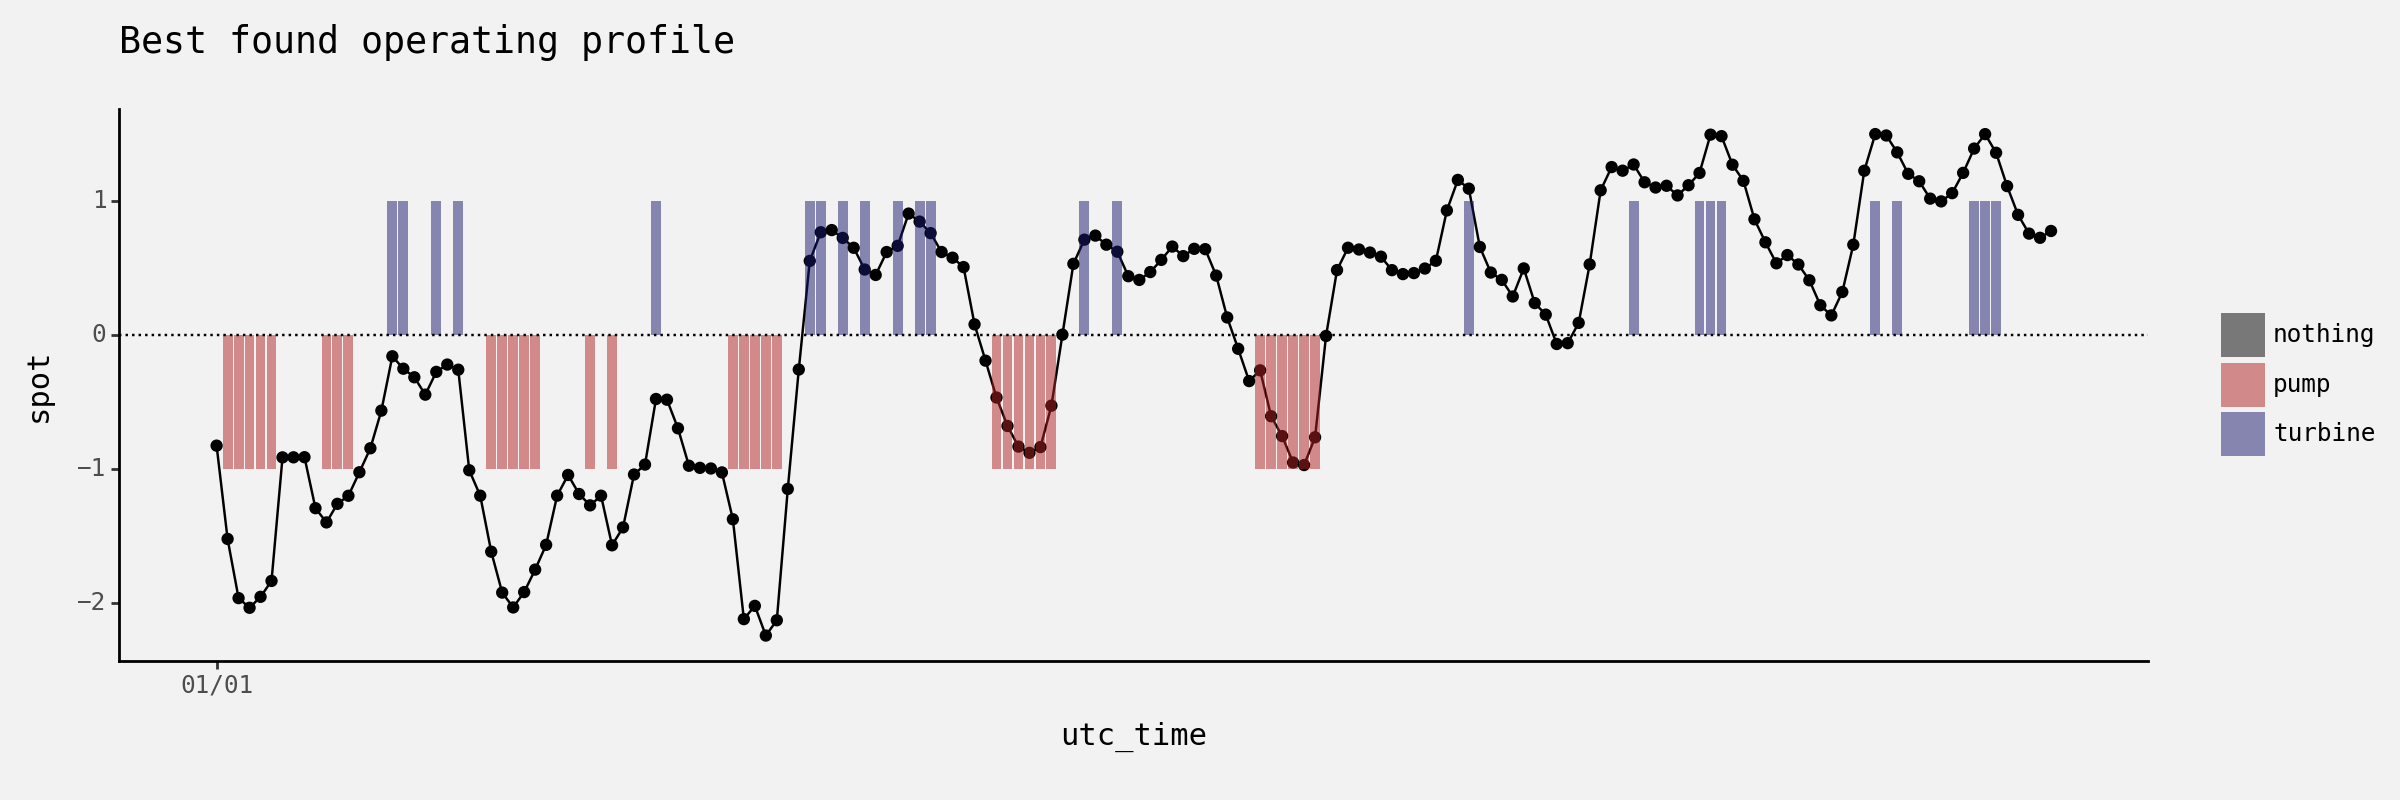

<Figure Size: (1200 x 400)>

In [30]:
(
    pn.ggplot(
        data=best_profile.assign(
            spot=lambda x: (x.spot - x.spot.mean()) / x.spot.std()
        ),
        mapping=pn.aes(x="utc_time"),
    )
    + pn.geom_line(pn.aes(y="spot"))
    + pn.geom_point(pn.aes(y="spot"))
    + pn.geom_col(pn.aes(y="action", fill="colour_id"), alpha=0.5)
    + pn.labs(title="Best found operating profile")
    + pn.scale_fill_manual(values=["black", "firebrick", "midnightblue"])
    + pn.geom_hline(yintercept=0, linetype="dotted")
    + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

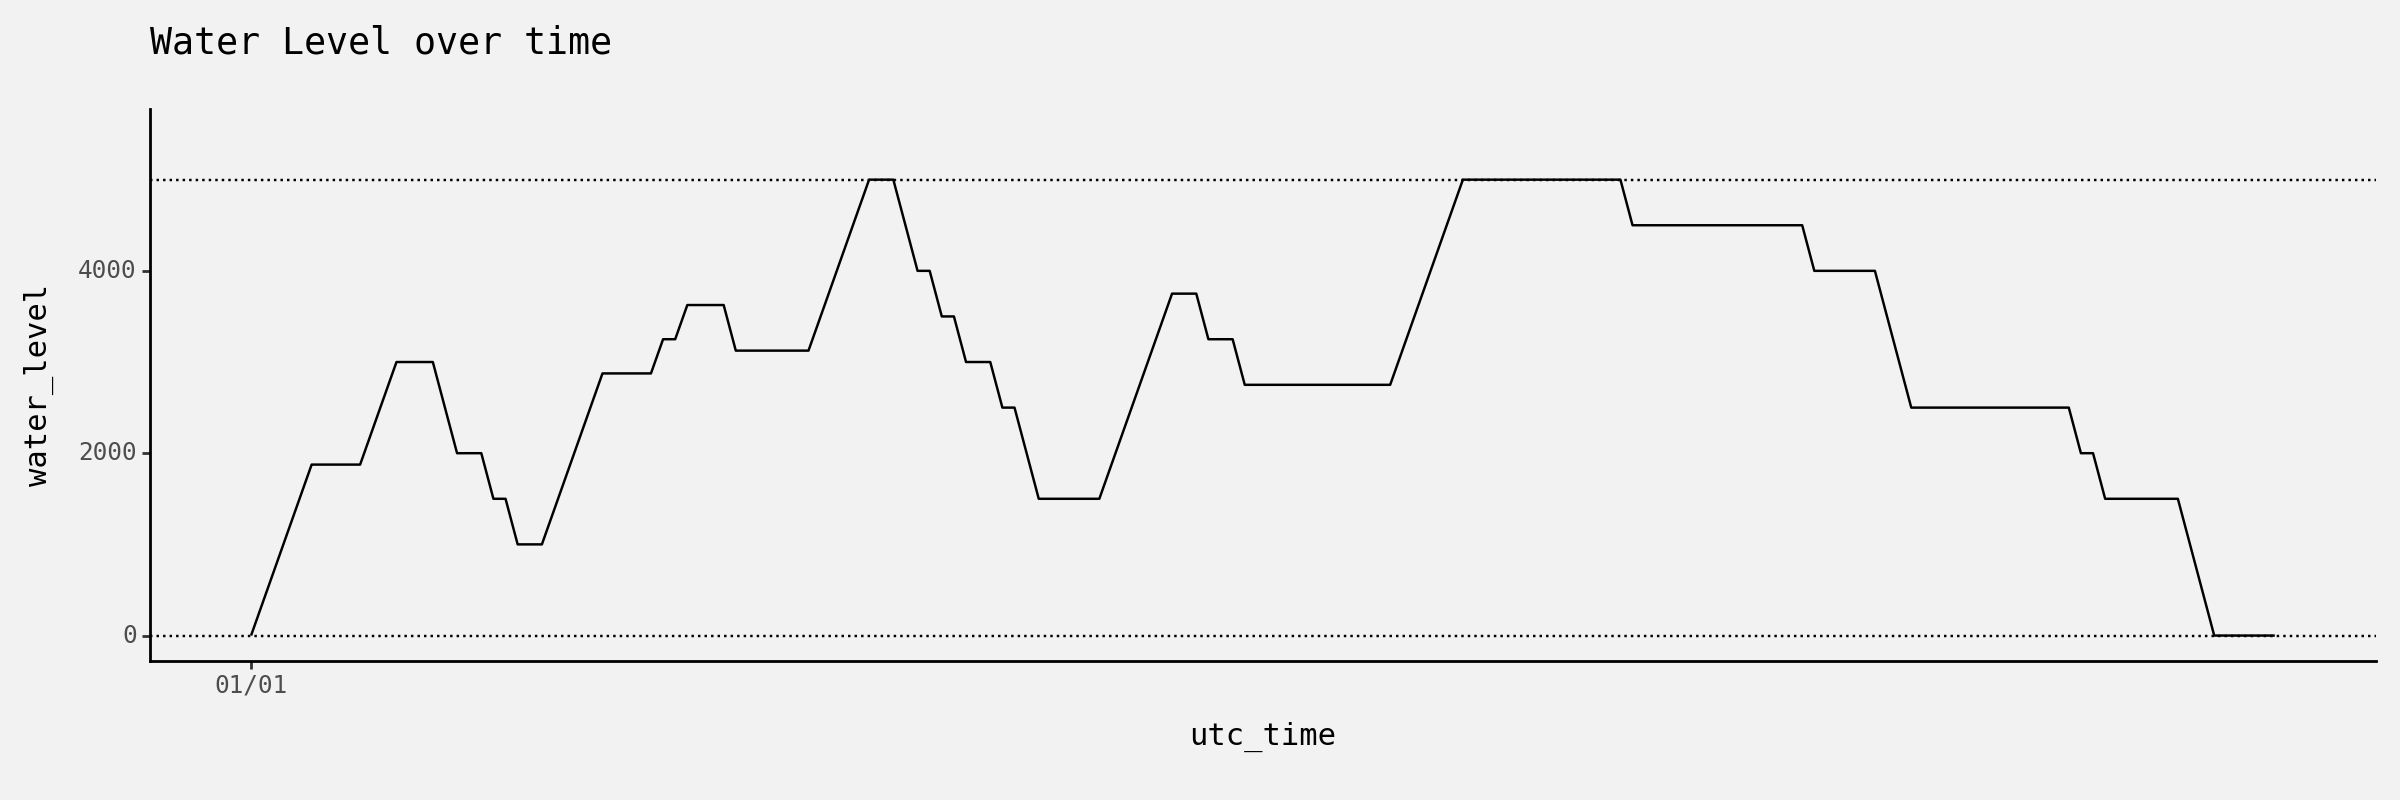

<Figure Size: (1200 x 400)>

In [32]:
(
    pn.ggplot(data=best_profile, mapping=pn.aes(x="utc_time", y="water_level"))
    + pn.geom_line()
    + pn.labs(title="Water Level over time")
    + pn.geom_hline(yintercept=plant_params["MAX_STORAGE_M3"], linetype="dotted")
    + pn.geom_hline(yintercept=plant_params["MIN_STORAGE_M3"], linetype="dotted")
    + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
    + pn.coord_cartesian(ylim=[0, best_profile.water_level.max()*1.1])
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

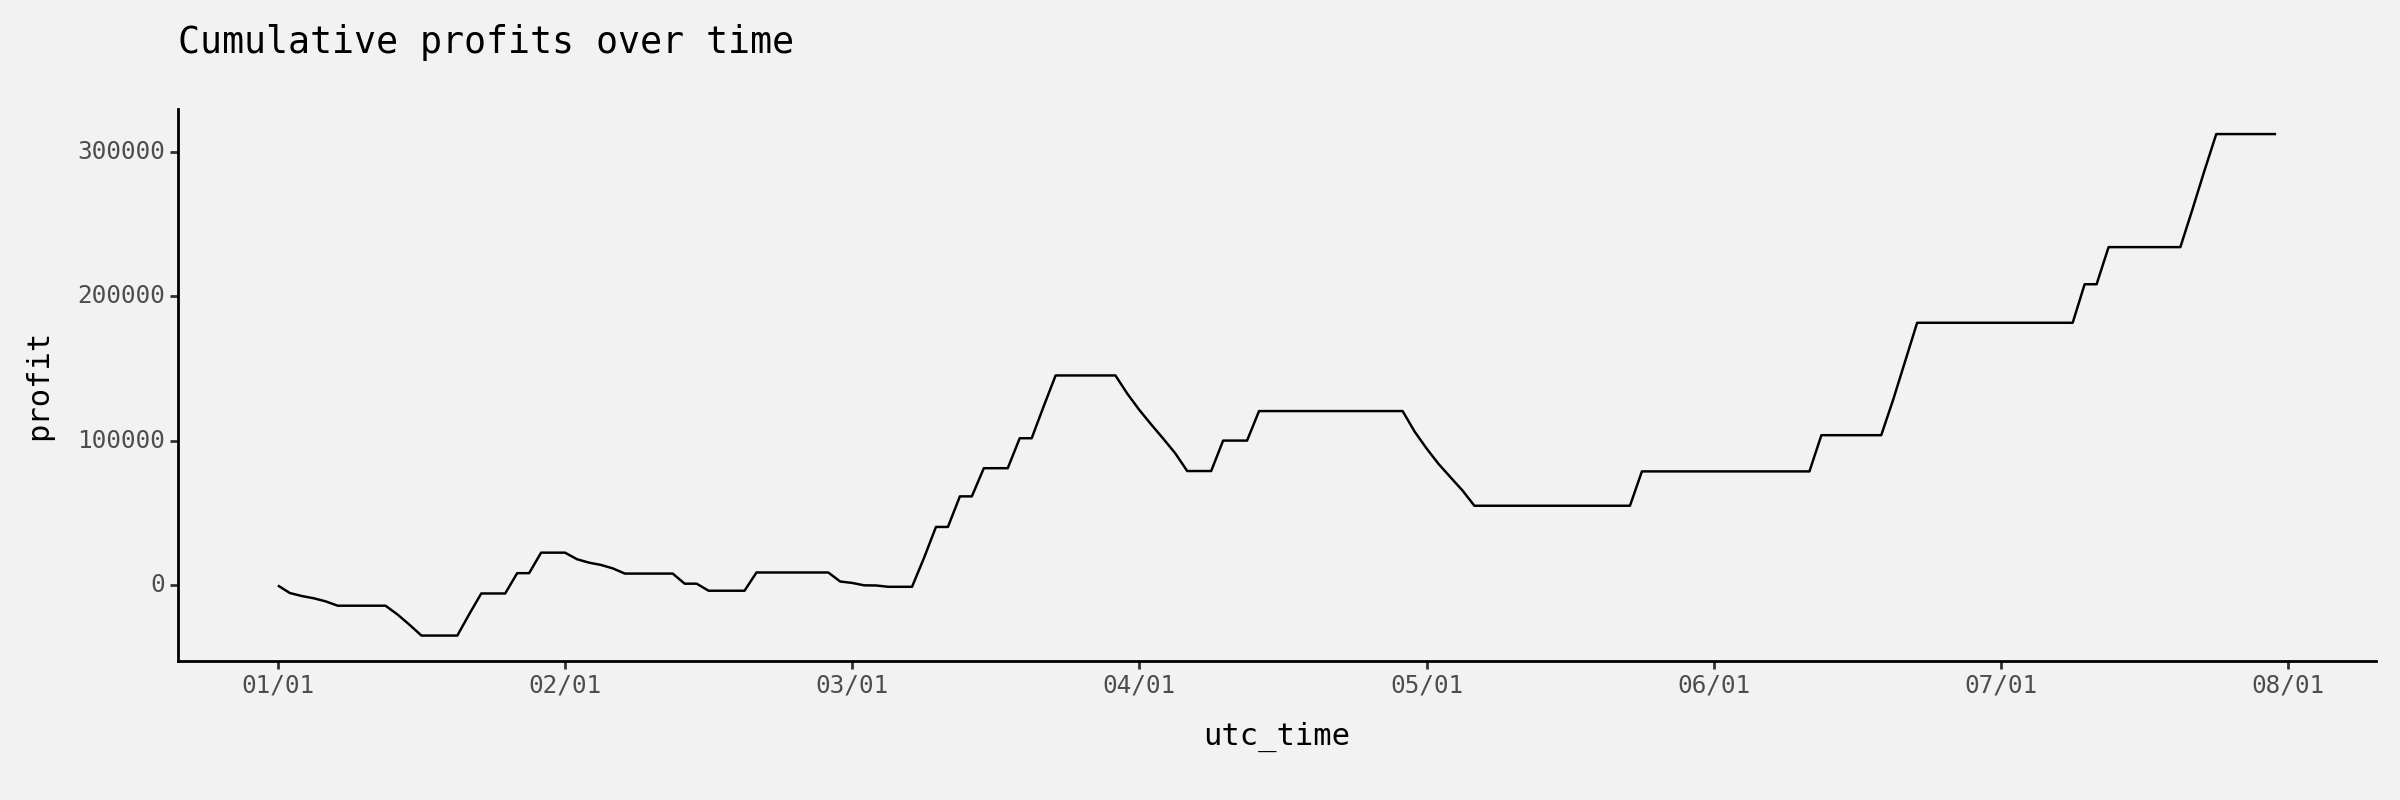

<Figure Size: (1200 x 400)>

In [33]:
(
    pn.ggplot(
        data=(
            best_profile.assign(
                profit=lambda x: np.select(
                    [x.action == -1, x.action == 1],
                    [
                        -plant_params["PUMP_POWER_MW"] * x.spot,
                        plant_params["TURBINE_POWER_MW"] * x.spot,
                    ],
                )
            ).assign(profit=lambda x: x.profit.cumsum())
        ),
        mapping=pn.aes(x="utc_time", y="profit"),
    )
    + pn.geom_line()
    + pn.labs(title="Cumulative profits over time")
    + pn.scale_x_date(date_breaks="1 day", date_labels="%d/%m")
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

In [14]:
ga.best_fitness

65706042.0

### Tuning the Hyperparameters with Optuna

In [ ]:
window_size = 24*3

example = prices.filter(
    pl.col("utc_time") >= pd.to_datetime("2022-07-18").tz_localize("UTC")
).head(window_size)

plant_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 4000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 100,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
plant_params["INITIAL_WATER_LEVEL"] = plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
plant_params["PUMP_RATE_M3H"] = plant_params["TURBINE_RATE_M3H"] * plant_params["EFFICIENCY"]
plant_params["MAX_STORAGE_MWH"] = (plant_params["MAX_STORAGE_M3"] / plant_params["TURBINE_RATE_M3H"]) * plant_params["TURBINE_POWER_MW"]

In [ ]:
def objective(trial):
    params = {
        "elitism": trial.suggest_float("elitism", 0, 0.5),
        "mutation_rate": trial.suggest_float("mutation_rate", 0, 0.5),
        "mutation_sigma": trial.suggest_float("mutation_sigma", 0, 0.5),
        "mutation_decay": trial.suggest_float("mutation_decay", 0.8, 0.9999),
    }

    ga = GA_discrete_actions(
        dna_size=window_size,
        discrete_action_space=[-1, 0, 1],
        elitism=params["elitism"],
        population_size=200,
        mutation_rate=params["mutation_rate"],
        mutation_sigma=params["mutation_sigma"],
        mutation_decay=params["mutation_decay"],
        mutation_limit=0.01,
    )

    population = ga.initial_population

    for generation in range(100):
        population = ga.evolve(
            population=population,
            fitnesses=evaluate_fitness(
                population=population, plant_params=plant_params, prices=example
            ),
        )
    
    return ga.average_fitness


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600*1)

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

In [ ]:
study.best_params

In [ ]:
study.best_value

### Formulating the Problem as MILP

First: Does it find global optimum?
How to specify the problem and constraints?
How to solve the problem numerically with Python?

### Genetic Algorithm Library in Python

Parallelise? More advanced types of genetic algorithm?

### NEAT

Make a decision with a neural network at every point in time.